In [1]:
import dask.dataframe as dd
import time
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [2]:
start_time = time.time()
train_df = dd.read_csv('train.csv').head(n=10000000, npartitions = 20)
train_df =  train_df.sample(frac = 0.5,replace=True)
print("Time taken to read = %s seconds" % (time.time() - start_time))

Time taken to read = 43.19577503204346 seconds


In [3]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
226884,2010-01-29 10:04:00.00000053,4.9,2010-01-29 10:04:00 UTC,-73.954200,40.728252,-73.953060,40.724268,5
252567,2011-06-22 20:21:07.0000007,7.3,2011-06-22 20:21:07 UTC,-73.984376,40.745847,-73.961132,40.760702,1
241013,2012-01-14 15:34:00.00000079,4.1,2012-01-14 15:34:00 UTC,0.000000,0.000000,0.000000,0.000000,2
338389,2009-12-30 20:13:30.0000005,3.3,2009-12-30 20:13:30 UTC,-73.973222,40.792907,-73.977952,40.786851,1
169371,2011-07-14 21:40:00.000000241,12.1,2011-07-14 21:40:00 UTC,-73.967680,40.765860,-73.994230,40.724773,1


###  **DATA CLEANING**
 - Passenger count cannot be negative or zero. Maximum number of passengers allowed is 7.
 - Minimum Fare amount for NYC cabs is 2.5 dollars.
 - Pickup lat/long and Dropoff lat/long cannot be the same. Check for valid lat/long (which cannot be outside the        range for lat --> -90 to 90 & longitude --> -180 to 180)
 - Convert the data type of 'pickup_datetime' to datetime

In [4]:
train_df.shape[0]

5000000

In [5]:
print('\033[1m'+"Passenger count <= 0: \n",train_df['passenger_count'][(train_df.passenger_count<=0)].count())

Passenger count <= 0: 
 17464


In [6]:
print('\033[1m'+"Passenger count > 7: \n",train_df['passenger_count'][(train_df['passenger_count'] > 7)].count())

Passenger count > 7: 
 11


In [7]:
#train_df[train_df['passenger_count']==0].head
#train_df[(train_df['passenger_count'] >7)].head

In [8]:
train_df = train_df[(train_df['passenger_count'] <= 7)]

In [9]:
train_df.shape[0]

4999989

In [10]:
print('\033[1m'+"Fare amount < 2.5: \n",train_df['fare_amount'][(train_df.fare_amount<2.5)].count())

Fare amount < 2.5: 
 376


In [11]:
print('\033[1m'+"Fare amount > 500: \n",train_df['fare_amount'][(train_df.fare_amount>500)].count())

Fare amount > 500: 
 3


In [12]:
train_df = train_df[(train_df.fare_amount>=2.5) & (train_df.fare_amount<=500)]

In [13]:
train_df.shape

(4999610, 8)

In [14]:
# latitude and longitude are bounded by 90 and -90. We shouldnt have any coordiantes out of that range
# train_df = train_df[(train_df['pickup_latitude']<=90) & (train_df['pickup_latitude']>=-90)]
# train_df = train_df[(train_df['pickup_longitude']<=180) & (train_df['pickup_longitude']>=-180)]
# train_df = train_df[(train_df['dropoff_latitude']<=90) & (train_df['dropoff_latitude']>=-90)]
# train_df = train_df[(train_df['dropoff_longitude']<=180) & (train_df['dropoff_longitude']>=-180)]

In [15]:
# train_df.shape[0]

Text(0, 0.5, 'Frequency')

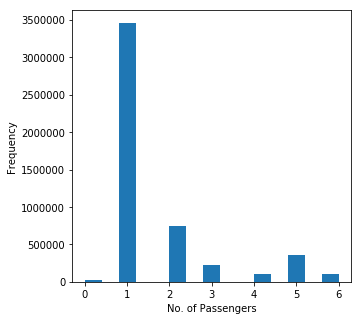

In [16]:
plt.figure(figsize=(5,5))
plt.hist(train_df['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

In [17]:
#fig, ax = plt.subplots()
#hist = ax.hist2d(train_df['passenger_count'], train_df['fare_amount'])
#plt.bar(train_df['passenger_count'], train_df['fare_amount'])
#ax.set_xticks(train_df['passenger_count'])
#plt.show(block=False)
index = np.arange(len(train_df['passenger_count']))
plt.bar(index, train_df['fare_amount'])
plt.xlabel('Genre', fontsize=5)
plt.ylabel('No of Movies', fontsize=5)
plt.xticks(index, train_df['passenger_count'], fontsize=5, rotation=30)
plt.title('Market Share for Each Genre 1995-2017')
plt.show()

Text(0, 0.5, 'Fare')

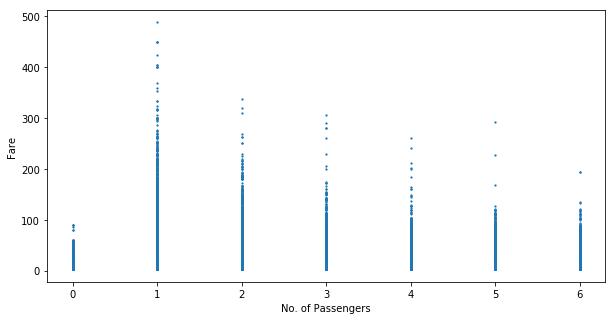

In [18]:
plt.figure(figsize=(10,5))
plt.scatter(x=train_df['passenger_count'], y=train_df['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

In [19]:
train_df.shape

(4999610, 8)

In [20]:
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [21]:
train_df['pickup_datetime']=dd.to_datetime(train_df['pickup_datetime'], infer_datetime_format=True)

In [22]:
train_df.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

### **FEATURE ENGINEERING**
 - Split the pickup_datetime column into day, month, year, day of week, hour, minute, second to verify if the fare 
   amount prediction depends on these parameters.
 - Calculate the haversine distance in miles using the pickup/dropoff latitude/longitude values  

In [23]:
#Time of day
train_df['Hour'] = train_df['pickup_datetime'].dt.hour
train_df['Minute'] = train_df['pickup_datetime'].dt.minute
train_df['Second'] = train_df['pickup_datetime'].dt.second

#Days of week 0-Monday 1-Tuesday 2-Wednesday 3-Thursday 4-Friday 5-Saturday 6-Sunday
train_df['day_of_week'] = train_df['pickup_datetime'].dt.weekday

#Date format mm dd year
train_df['Month'] = train_df['pickup_datetime'].dt.month
train_df['Date'] = train_df['pickup_datetime'].dt.day
train_df['Year'] = train_df['pickup_datetime'].dt.year

In [24]:
train_df['Hour'].describe()

count    4.999610e+06
mean     1.351130e+01
std      6.517827e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.400000e+01
75%      1.900000e+01
max      2.300000e+01
Name: Hour, dtype: float64

In [25]:
train_df['day_of_week'].describe()

count    4.999610e+06
mean     3.040851e+00
std      1.949152e+00
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      6.000000e+00
Name: day_of_week, dtype: float64

In [32]:
def over_night (row):
    if (row['Hour'] >= 20) or (row['Hour'] <= 6):
        return 1
    else:
        return 0


def rush_hour (row):
    if ((row['Hour'] >=16) and (row['Hour'] <= 20)) and (row['day_of_week'] <= 4):
        return 1
    else:
        return 0
    
train_df['rush_hour'] = train_df.apply(lambda x: rush_hour(x), axis=1)
train_df['over_night'] = train_df.apply(lambda x: over_night(x), axis=1)   

In [34]:
#print(data.describe())
def distance(data):
    R = 3956        # Radius of earth in miles
    
    pickup_data = data[['pickup_longitude','pickup_latitude']]
    dropoff_data = data[['dropoff_longitude','dropoff_latitude']]
    
    phi1 = np.radians(pickup_data['pickup_latitude'])
    phi2 = np.radians(dropoff_data['dropoff_latitude'])
    
    delta_phi = np.radians(dropoff_data['dropoff_latitude'] - pickup_data['pickup_latitude'])
    delta_lambda = np.radians(dropoff_data['dropoff_longitude'] - pickup_data['pickup_longitude'])
    
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin((delta_phi)/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2)**2
    
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = R * c
    
    return d

# add new column to dataframe with distance in miles
train_df['distance_in_miles'] = distance(train_df)
# train_df['distance_in_miles'] = distance(train_df.pickup_latitude, train_df.pickup_longitude,
#                                       train_df.dropoff_latitude, train_df.dropoff_longitude)

In [35]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

In [29]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 4999610
New size: 4999566


In [36]:
def distanceNyc(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 3.0) & (train_df.abs_diff_latitude < 3.0)]
train_df = train_df[(train_df.pickup_longitude >= -74.3) & (train_df.pickup_longitude <= -72.9)]  # nyc coordinates
train_df = train_df[(train_df.dropoff_longitude >= -74.3) & (train_df.dropoff_longitude <= -72.9)]
train_df = train_df[(train_df.pickup_latitude >= 40.5) & (train_df.pickup_latitude <= 41.8)]
train_df = train_df[(train_df.dropoff_latitude >= 40.5) & (train_df.dropoff_latitude <= 41.8)]
train_df = train_df[(train_df.distance_in_miles<=100.0) & (train_df.distance_in_miles>0.05)]
nyc = (-74.0063889, 40.7141667)
train_df['distance_to_center'] = distanceNyc(nyc[1], nyc[0],train_df.dropoff_latitude, train_df.dropoff_longitude)
train_df = train_df[train_df.distance_to_center<15.0]
print('New size: %d' % len(train_df))

In [31]:
(train_df.head())

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Minute,...,day_of_week,Month,Date,Year,rush_hour,over_night,distance_in_miles,abs_diff_longitude,abs_diff_latitude,distance_to_center
226884,2010-01-29 10:04:00.00000053,4.9,2013-03-22 23:54:55,-73.954200,40.728252,-73.953060,40.724268,5,23,54,...,4,3,22,2013,0,1,0.281469,0.001140,0.003984,2.878561
252567,2011-06-22 20:21:07.0000007,7.3,2011-10-04 02:56:00,-73.984376,40.745847,-73.961132,40.760702,1,2,56,...,1,10,4,2011,0,1,1.590607,0.023244,0.014855,3.993954
338389,2009-12-30 20:13:30.0000005,3.3,2013-09-06 22:44:33,-73.973222,40.792907,-73.977952,40.786851,1,22,44,...,4,9,6,2013,0,1,0.485774,0.004730,0.006056,5.237936
169371,2011-07-14 21:40:00.000000241,12.1,2011-07-14 00:41:00,-73.967680,40.765860,-73.994230,40.724773,1,0,41,...,3,7,14,2011,0,1,3.158580,0.026550,0.041087,0.970797
518559,2010-07-20 08:13:00.000000155,12.5,2009-04-23 19:24:39,-73.993978,40.755573,-73.953847,40.787927,1,19,24,...,3,4,23,2009,1,0,3.064899,0.040131,0.032354,5.791027


In [32]:
train_df.dtypes

key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
Hour                           int64
Minute                         int64
Second                         int64
day_of_week                    int64
Month                          int64
Date                           int64
Year                           int64
rush_hour                      int64
over_night                     int64
distance_in_miles            float64
abs_diff_longitude           float64
abs_diff_latitude            float64
distance_to_center           float64
dtype: object

In [34]:
train_df.to_csv('FinalData.csv')

In [2]:
columns = ['fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'Hour', 'Minute', 'Second',
       'day_of_week', 'Month', 'Date', 'Year', 'rush_hour', 'over_night',
       'distance_in_miles', 'abs_diff_longitude', 'abs_diff_latitude',
       'distance_to_center']
learning_data = pd.read_csv('FinalData.csv',usecols = columns).sample(n=1000000)

In [3]:
learning_data.shape

(1000000, 20)

In [5]:
learning_data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'Hour',
       'Minute', 'Second', 'day_of_week', 'Month', 'Date', 'Year', 'rush_hour',
       'over_night', 'distance_in_miles', 'abs_diff_longitude',
       'abs_diff_latitude', 'distance_to_center'],
      dtype='object')

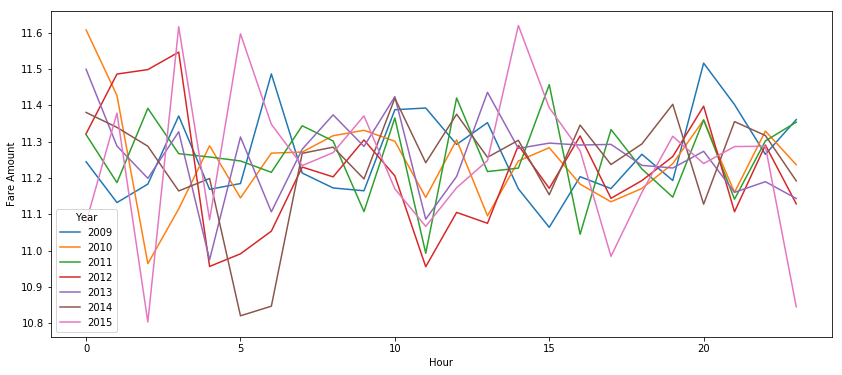

In [6]:
# display pivot table
learning_data.pivot_table('fare_amount', index='Hour', columns='Year').plot(figsize=(14,6))
plt.ylabel('Fare Amount');
# plt.axis([0, 23, 0, 20])

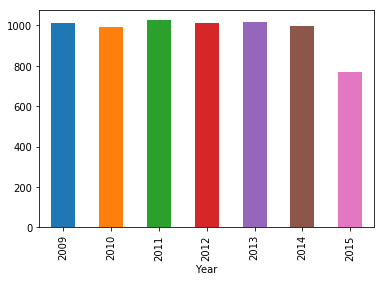

In [40]:
learning_data.groupby('Year')['fare_amount'].nunique().plot(kind='bar')
plt.show()

## MODEL SELECTION

In [4]:
y = learning_data['fare_amount']

In [5]:
X = learning_data.drop(['fare_amount','pickup_datetime','abs_diff_longitude','abs_diff_latitude'],axis = 1)

In [6]:
X.shape

(1000000, 16)

In [7]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Minute,Second,day_of_week,Month,Date,Year,rush_hour,over_night,distance_in_miles,distance_to_center
788623,-74.005759,40.748474,-73.997412,40.750903,1,21,19,0,2,7,30,2014,0,1,0.467706,2.581381
2902056,-73.966445,40.753672,-73.961831,40.760177,1,15,40,8,4,6,27,2014,0,0,0.509862,3.943057
4076143,-73.999831,40.731067,-73.978329,40.750960,1,15,3,0,2,2,16,2011,0,0,1.775335,2.936143
861358,-73.958765,40.781147,-73.956852,40.775887,2,15,31,41,6,9,11,2011,0,0,0.376699,4.990965
1563195,-73.980267,40.745608,-73.979402,40.727668,1,17,54,39,1,4,19,2011,1,0,1.239498,1.693310


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size = .3)

In [9]:
X_train.shape[0]

700000

In [10]:
y_train.shape[0]

700000

In [11]:
X_val.shape[0]

300000

In [12]:
y_val.shape[0]

300000

In [13]:
X_train.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'Hour', 'Minute', 'Second',
       'day_of_week', 'Month', 'Date', 'Year', 'rush_hour', 'over_night',
       'distance_in_miles', 'distance_to_center'],
      dtype='object')

### LINEAR REGRESSION

In [14]:
start_time = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
#print("-------LINEAR REGRESSION------")
print("Training score: ",lr.score(X_train,y_train))
print("Validation score: ",lr.score(X_val,y_val))

y_pred = lr.predict(X_val)
print("Predicted output: ",y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_val))
print("Mean Squared Error: ",rmse)
print("Time taken = %s seconds" % (time.time() - start_time))

Training score:  0.7573774163522184
Validation score:  0.7686311221630346
Predicted output:  [11.16271481  7.48541771  8.09489176 ...  4.4398429   7.94670568
 22.08520195]
Mean Squared Error:  4.452795485726173
Time taken = 0.6017501354217529 seconds


### DECISION TREE REGRESSOR

In [15]:
start_time = time.time()
modelTreeReg = tree.DecisionTreeRegressor()
modelTreeReg.fit(X_train, y_train)

predictTreeReg = modelTreeReg.predict(X_val)
print("Predicted output: ",predictTreeReg)
tree_mse = mean_squared_error(y_val, predictTreeReg)
treeRMSE = np.sqrt(tree_mse)
print("Mean Squared error: ",treeRMSE)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [10.    6.5   7.5  ...  2.9   6.9  26.27]
Mean Squared error:  4.959801824972445
Time taken = 20.251168727874756 seconds


In [16]:
start_time = time.time()
modelTreeReg1 = tree.DecisionTreeRegressor(max_depth=2)
modelTreeReg1.fit(X_train, y_train)

predictTreeReg1 = modelTreeReg1.predict(X_val)
print("Predicted output: ",predictTreeReg1)
tree_mse1 = mean_squared_error(y_val, predictTreeReg1)
treeRMSE1 = np.sqrt(tree_mse1)
print("Mean Squared error: ",treeRMSE1)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [14.19220152  7.30267098  7.30267098 ...  7.30267098  7.30267098
 28.48339141]
Mean Squared error:  4.617899502464821
Time taken = 1.8477890491485596 seconds


In [17]:
start_time = time.time()
modelTreeReg2 = tree.DecisionTreeRegressor(max_depth=5)
modelTreeReg2.fit(X_train, y_train)

predictTreeReg2 = modelTreeReg2.predict(X_val)
print("Predicted output: ",predictTreeReg2)
tree_mse2 = mean_squared_error(y_val, predictTreeReg2)
treeRMSE2 = np.sqrt(tree_mse2)
print("Mean Squared error: ",treeRMSE2)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [11.59668056  7.92546064  7.92546064 ...  5.38395694  7.09378848
 21.23662575]
Mean Squared error:  3.8076026485501453
Time taken = 4.355047225952148 seconds


In [18]:
start_time = time.time()
modelTreeReg3 = tree.DecisionTreeRegressor(max_depth=7,random_state=0)
modelTreeReg3.fit(X_train, y_train)

predictTreeReg3 = modelTreeReg3.predict(X_val)
print("Predicted output: ",predictTreeReg3)
tree_mse3 = mean_squared_error(y_val, predictTreeReg3)
treeRMSE3 = np.sqrt(tree_mse3)
print("Mean Squared error: ",treeRMSE3)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [11.22469101  8.06896537  8.06896537 ...  5.09338072  7.23106924
 20.64108699]
Mean Squared error:  3.7096206412350914
Time taken = 6.155409812927246 seconds


### RANDOM FOREST REGRESSOR

In [19]:
start_time = time.time()
randomForest = RandomForestRegressor(n_estimators=10,random_state=0)
randomForest.fit(X_train, y_train)

#print("---------RANDOM FOREST----------")
print("Training score: ",randomForest.score(X_train,y_train))
print("Validation score: ",randomForest.score(X_val,y_val))

randomForestPredict = randomForest.predict(X_val)
print("Predicted output: ",randomForestPredict)
randomForest_RMSE = np.sqrt(mean_squared_error(y_val, randomForestPredict))
print("Mean Squared error: ",randomForest_RMSE)
print("Time taken = %s seconds" % (time.time() - start_time))

Training score:  0.9721979984755187
Validation score:  0.848868351535243
Predicted output:  [10.84  7.61  7.92 ...  7.5   8.6  24.84]
Mean Squared error:  3.59880229123848
Time taken = 144.17272019386292 seconds


### IMPROVED RANDOM FOREST REGRESSOR

In [20]:
start_time = time.time()
model = RandomForestRegressor(n_estimators=25, max_features=6, max_depth=25, min_samples_split=3,
                              min_samples_leaf=2, random_state=0)
randomForestImproved = model.fit(X_train,y_train)

#print("---------IMPROVED RANDOM FOREST------------")
randomForestImprovedPredict = randomForestImproved.predict(X_val)
print("Predicted output: ",randomForestImprovedPredict)
randomForestImproved_mse = mean_squared_error(y_val, randomForestImprovedPredict)
randomForestImprovedMSE = np.sqrt(randomForestImproved_mse)
print("Mean Squared error: ",randomForestImprovedMSE)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [10.87870374  8.18934255  7.38880735 ...  5.01548786  7.87016167
 25.50024723]
Mean Squared error:  3.397291402804007
Time taken = 120.80817890167236 seconds


In [21]:
start_time = time.time()
model1 = RandomForestRegressor(n_estimators=15, max_features=3, max_depth=20, min_samples_split=2,
                              min_samples_leaf=2, random_state=0)
randomForestImproved1 = model1.fit(X_train,y_train)

print("---------IMPROVED RANDOM FOREST------------")
randomForestImprovedPredict1 = randomForestImproved1.predict(X_val)
print("Predicted output: ",randomForestImprovedPredict1)
randomForestImproved_mse1 = mean_squared_error(y_val, randomForestImprovedPredict1)
randomForestImprovedMSE1 = np.sqrt(randomForestImproved_mse1)
print("Mean Squared error: ",randomForestImprovedMSE1)
print("Time taken = %s seconds" % (time.time() - start_time))

---------IMPROVED RANDOM FOREST------------
Predicted output:  [10.71868988  8.34052252  7.56086137 ...  5.96895143  7.49555135
 23.06265865]
Mean Squared error:  3.518081263888207
Time taken = 33.77506899833679 seconds


In [22]:
start_time = time.time()
model2 = RandomForestRegressor(n_estimators=25, max_features=8, max_depth=25, min_samples_split=3,
                              min_samples_leaf=3, random_state=30)
randomForestImproved2 = model2.fit(X_train,y_train)

#print("---------IMPROVED RANDOM FOREST------------")
randomForestImprovedPredict2 = randomForestImproved2.predict(X_val)
print("Predicted output: ",randomForestImprovedPredict2)
randomForestImproved_mse2 = mean_squared_error(y_val, randomForestImprovedPredict2)
randomForestImprovedMSE2 = np.sqrt(randomForestImproved_mse2)
print("Mean Squared error: ",randomForestImprovedMSE2)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [11.64329876  8.41464265  6.94135736 ...  5.3092418   7.80579581
 24.24243053]
Mean Squared error:  3.395879822974272
Time taken = 154.41515707969666 seconds


In [23]:
start_time = time.time()
model3 = RandomForestRegressor(n_estimators=20, max_features=5, max_depth=20, min_samples_split=3,
                              min_samples_leaf=2, random_state=0)
randomForestImproved3 = model3.fit(X_train,y_train)

#print("---------IMPROVED RANDOM FOREST------------")
randomForestImprovedPredict3 = randomForestImproved3.predict(X_val)
print("Predicted output: ",randomForestImprovedPredict3)
randomForestImproved_mse3 = mean_squared_error(y_val, randomForestImprovedPredict3)
randomForestImprovedMSE3 = np.sqrt(randomForestImproved_mse3)
print("Mean Squared error: ",randomForestImprovedMSE3)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [11.00199044  8.47829927  7.35853498 ...  6.915717    7.84382799
 23.22388091]
Mean Squared error:  3.4267563710766846
Time taken = 75.16972517967224 seconds


Text(0.5, 1.0, 'Feature Importance for Random Forest')

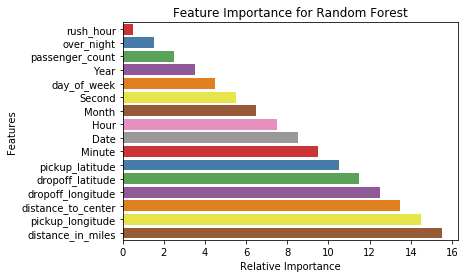

In [61]:
feature_importance = randomForestImproved.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
sns.barplot(pos,X_train.columns[sorted_idx], palette = 'Set1')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Random Forest')

In [21]:
regression = pd.DataFrame({"regression": ['Linear Regression','Decision Tree','Random Forest', 'Tuned Random Forest'],
                           "rmse": [rmse,treeRMSE3,randomForest_RMSE,randomForestImprovedMSE2]},
                            columns = ['regression','rmse'])

In [22]:
regression = regression.sort_values(by='rmse', ascending = False)

Text(0.5, 1.0, 'Comparing the different types of Regressions used')

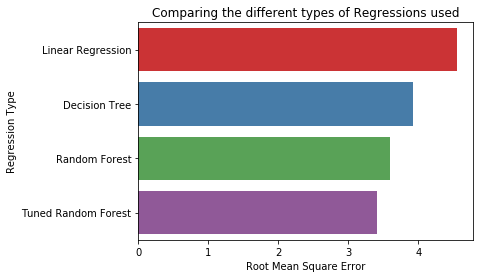

In [23]:
sns.barplot(regression['rmse'],regression['regression'], palette = 'Set1')
plt.ylabel('Regression Type')
plt.xlabel("Root Mean Square Error")
plt.title('Comparing the different types of Regressions used')

In [62]:
from yellowbrick.regressor import ResidualsPlot

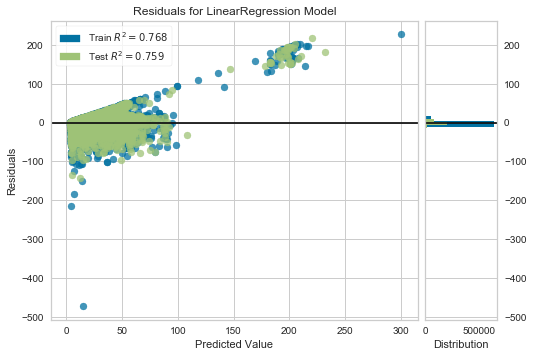

In [59]:
visualizerDT = ResidualsPlot(lr)

visualizerDT.fit(X_train, y_train)  # Fit the training data to the model
visualizerDT.score(X_val, y_val)  # Evaluate the model on the test data
visualizerDT.poof()                 # Draw/show/poof the data

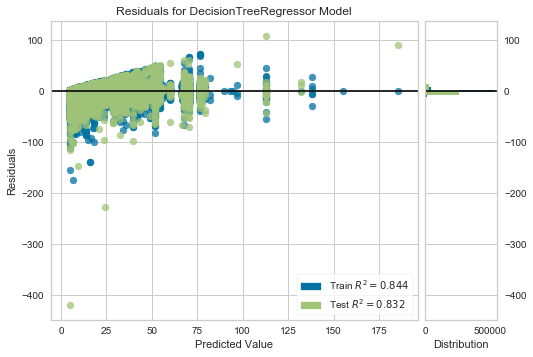

In [63]:
visualizerDT = ResidualsPlot(modelTreeReg3)

visualizerDT.fit(X_train, y_train)  # Fit the training data to the model
visualizerDT.score(X_val, y_val)  # Evaluate the model on the test data
visualizerDT.poof()                 # Draw/show/poof the data

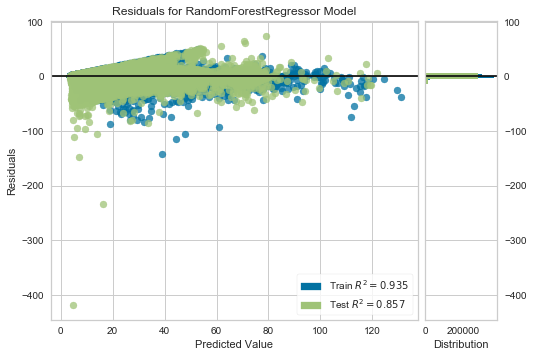

In [64]:
# Instantiate the visualizer
visualizer = ResidualsPlot(model2)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

### FEATURE CORRELATION

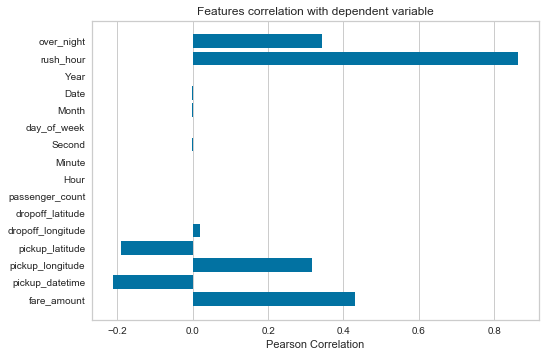

In [65]:
from yellowbrick.target import FeatureCorrelation

# Load the regression data set
# data = datasets.load_diabetes()
# X, y = data['data'], data['target']
feature_names = np.array(columns)

visualizer = FeatureCorrelation(labels=feature_names)
visualizer.fit(X, y)
visualizer.poof()

In [25]:
test_data = dd.read_csv('test.csv').head(n=9914)
test_data = test_data.sample(frac = 1,replace=True)

In [26]:
test_data.shape[0]

9914

In [27]:
test_data.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [37]:
test_data = test_data[(test_data['passenger_count'] <= 7)]

test_data['pickup_datetime']=dd.to_datetime(test_data['pickup_datetime'], infer_datetime_format=True)

#Time of day
test_data['Hour'] = test_data['pickup_datetime'].dt.hour
test_data['Minute'] = test_data['pickup_datetime'].dt.minute
test_data['Second'] = test_data['pickup_datetime'].dt.second

#Days of week 0-Monday 1-Tuesday 2-Wednesday 3-Thursday 4-Friday 5-Saturday 6-Sunday
test_data['day_of_week'] = test_data['pickup_datetime'].dt.weekday

#Date format mm dd year
test_data['Month'] = test_data['pickup_datetime'].dt.month
test_data['Date'] = test_data['pickup_datetime'].dt.day
test_data['Year'] = test_data['pickup_datetime'].dt.year

test_data['rush_hour'] = test_data.apply(lambda x: rush_hour(x), axis=1)
test_data['over_night'] = test_data.apply(lambda x: over_night(x), axis=1)   

test_data['distance_in_miles'] = distance(test_data)
add_travel_vector_features(test_data)
test_data = test_data.dropna(how = 'any', axis = 'rows')

test_data = test_data[(test_data.abs_diff_longitude < 3.0) & (test_data.abs_diff_latitude < 3.0)]
test_data = test_data[(test_data.pickup_longitude >= -74.3) & (test_data.pickup_longitude <= -72.9)]  # nyc coordinates
test_data = test_data[(test_data.dropoff_longitude >= -74.3) & (test_data.dropoff_longitude <= -72.9)]
test_data = test_data[(test_data.pickup_latitude >= 40.5) & (test_data.pickup_latitude <= 41.8)]
test_data = test_data[(test_data.dropoff_latitude >= 40.5) & (test_data.dropoff_latitude <= 41.8)]
test_data = test_data[(test_data.distance_in_miles<=100.0) & (test_data.distance_in_miles>0.05)]
nyc = (-74.0063889, 40.7141667)
test_data['distance_to_center'] = distanceNyc(nyc[1], nyc[0],test_data.dropoff_latitude, test_data.dropoff_longitude)
test_data = test_data[test_data.distance_to_center<15.0]

In [38]:
test_data.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'Hour',
       'Minute', 'Second', 'day_of_week', 'Month', 'Date', 'Year', 'rush_hour',
       'over_night', 'distance_in_miles', 'abs_diff_longitude',
       'abs_diff_latitude', 'distance_to_center'],
      dtype='object')

In [39]:
test_data.dtypes

key                           object
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
Hour                           int64
Minute                         int64
Second                         int64
day_of_week                    int64
Month                          int64
Date                           int64
Year                           int64
rush_hour                      int64
over_night                     int64
distance_in_miles            float64
abs_diff_longitude           float64
abs_diff_latitude            float64
distance_to_center           float64
dtype: object

In [40]:
test_data = test_data.drop(['key', 'pickup_datetime','abs_diff_longitude','abs_diff_latitude'],axis = 1)

In [47]:
start_time = time.time()
LRPredY = lr.predict(test_data)
print("Predicted output: ",LRPredY)
#rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_val))
#print("Mean Squared Error: ",rmse)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [40.31561528  7.40139111  6.87379329 ... 14.20763785  5.8977215
  5.49795883]
Time taken = 0.002838134765625 seconds


In [48]:
start_time = time.time()
RFPredY = randomForest.predict(test_data)
print("Predicted output: ",RFPredY)
#rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_val))
#print("Mean Squared Error: ",rmse)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [35.16   6.36   6.41  ... 16.393  5.41   4.7  ]
Time taken = 0.5625829696655273 seconds


In [49]:
start_time = time.time()
RFImpvPredY = model2.predict(test_data)
print("Predicted output: ",RFImpvPredY)
#rmse = np.sqrt(metrics.mean_squared_error(y_pred, y_val))
#print("Mean Squared Error: ",rmse)
print("Time taken = %s seconds" % (time.time() - start_time))

Predicted output:  [34.77848571  7.31405412  6.31392626 ... 17.26318842  5.09570301
  4.55909892]
Time taken = 0.14949584007263184 seconds


In [50]:
test_data['fare_amount'] = RFImpvPredY

In [51]:
test_data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Hour,Minute,Second,day_of_week,Month,Date,Year,rush_hour,over_night,distance_in_miles,distance_to_center,fare_amount
9725,-73.788612,40.641563,-73.957230,40.674271,5,14,58,0,0,10,27,2014,0,0,9.116079,3.772357,34.778486
6407,-73.988188,40.769900,-74.000088,40.758312,1,17,32,33,5,12,11,2010,0,0,1.013620,3.067932,7.314054
2243,-73.979987,40.780682,-73.966805,40.789167,1,7,29,0,3,12,9,2010,0,0,0.904506,5.580860,6.313926
1259,-73.990772,40.769852,-73.980782,40.762085,1,0,16,0,0,6,23,2014,0,1,0.748670,3.571941,7.718769
4147,-73.961735,40.756937,-73.978459,40.752911,1,2,57,0,6,4,27,2014,0,1,0.917812,3.050322,8.433076


In [52]:
test_data.to_csv('PredictedOutput.csv')

In [68]:
dataX = X_train[:2000]
dataY = y_train[:2000]
valX = X_val[:2000]
valY = y_val[:2000]

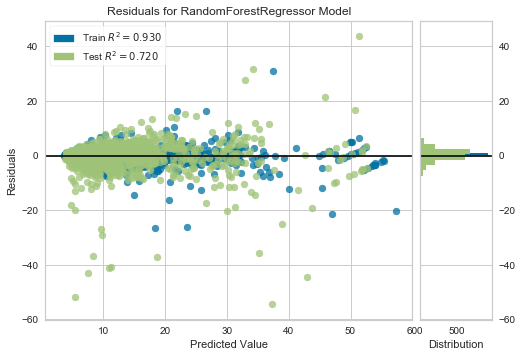

In [69]:
# Instantiate the visualizer
visualizer = ResidualsPlot(model2)

visualizer.fit(dataX, dataY)  # Fit the training data to the model
visualizer.score(valX, valY)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

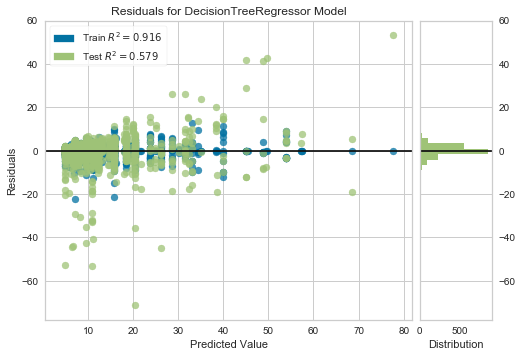

In [70]:
# Instantiate the visualizer
visualizer = ResidualsPlot(modelTreeReg3)

visualizer.fit(dataX, dataY)  # Fit the training data to the model
visualizer.score(valX, valY)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

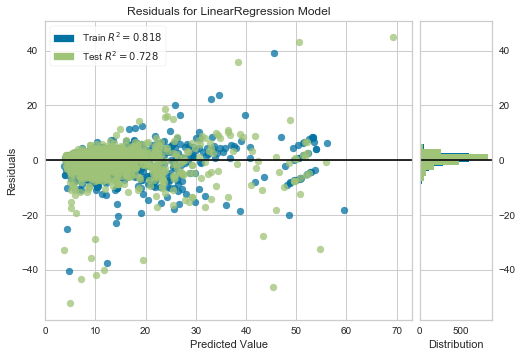

In [71]:
# Instantiate the visualizer
visualizer = ResidualsPlot(lr)

visualizer.fit(dataX, dataY)  # Fit the training data to the model
visualizer.score(valX, valY)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data